# Summarizing Time Series Data with Snippets

This tutorial is adapted from the [Matrix Profile XIII](https://www.cs.ucr.edu/~eamonn/Time_Series_Snippets_10pages.pdf) paper and replicates Figures 7,8 and 13.

One of common analysis query on a data is "Show me some representative/typical data". Sometimes, it is useful to summarize a time series into a few representative patterns (snippets) as it can be visualized more easily and some new insights might be discovered. 

For instance, let's consider a simple problem: ?

The "snippet-finder" algorithm proposed in the paper can be utilized to summarize a time series into a user-defined number of snippets. 

To demonstrate the usefulness of Snippets, we first create a toy data used in the original paper and will use the [STUMPY](https://pypi.org/project/stumpy/) library to discover the snippets in the data. This tutorial replicates the figures 7,8 and 13 of the original paper.

## Snippets vs. 

### - Clustering: 
Snippet is a different task than clustering. In a single time series, one can first extract subsequences (with a user-defined time window) and then perform clustering on the set of subsequences. However, as comprehensively studied in Eamonn Keogh and Jessica Lin (2005), clustering the subsequences of single time series leads to meaningless result. In some cases where there is a periodic behaviour (e.g. electricity demand), the clustering can be performed. However, algorithms specialized in clustering the electricity demand data into seasons, for instance, are more complex and requires more domain knowledge (for example: the subsequences must be exactly one-week long.) However, the snippets algorithm is domain-free and it can be used to better explore and analyze data.

### - Semantic Segmentation:
The snippets are different than semantic segmentation proposed in [Matrix Profile VIII](https://www.cs.ucr.edu/~eamonn/Segmentation_ICDM.pdf). In semantic segmentation, the task is to find boundary locations, not in explaining them, or producing representative patterns.

### - Shapelets:

There are two main differences between Time Series Snippets and [Shapelets](https://link.springer.com/article/10.1007/s10618-017-0519-9). For one, the shapelets are supervised; however, the snippets are unsupervised. For another, the shapelets are usually shorter whereas the snippets are preferred to be longer to capture the behavior of the time series at a higher level.

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, resample_poly

plt.style.use('stumpy.mplstyle')

## Retrieve the Data

It is the same toy data set used in the original paper. 

In [2]:
df = pd.read_csv("https://zenodo.org/record/4662217/files/snippets.csv?download=1")
df.head()

,toy
0,0.347609
1,0.350937
2,0.357541
3,0.367308
4,0.380056


## Visualizing the Raw Data

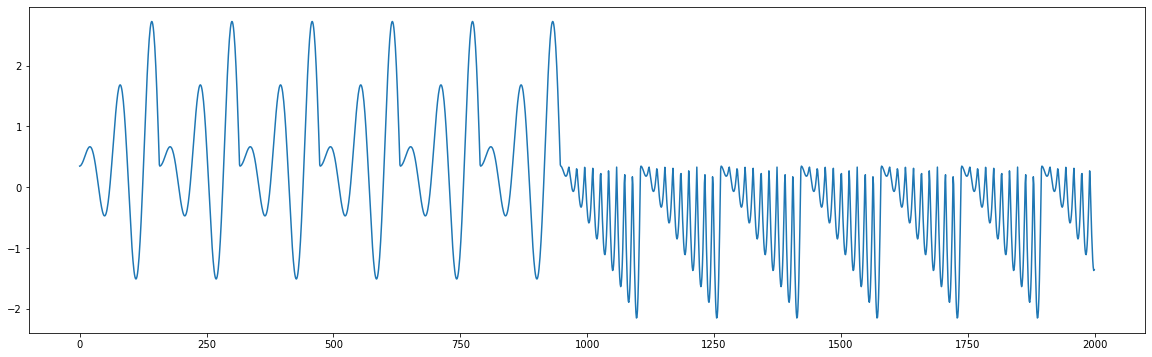

In [3]:
plt.plot(df)
plt.show()

## Adding noise to the data


In [4]:
def warp_add_noise(T):
    T = np.asarray(T).flatten()
    idx = np.arange(T.shape[0])
    np.random.shuffle(idx)
    idx = np.sort(idx[:-np.floor(T.shape[0] * 0.1).astype(int)])
    warped_T = resample_poly(T[idx], T.shape[0], idx.shape[0])
    noise = np.random.normal(0, 0.05, warped_T.shape)
    return warped_T + noise

In [5]:
T = warp_add_noise(df)

## Visualizing the Data with noise

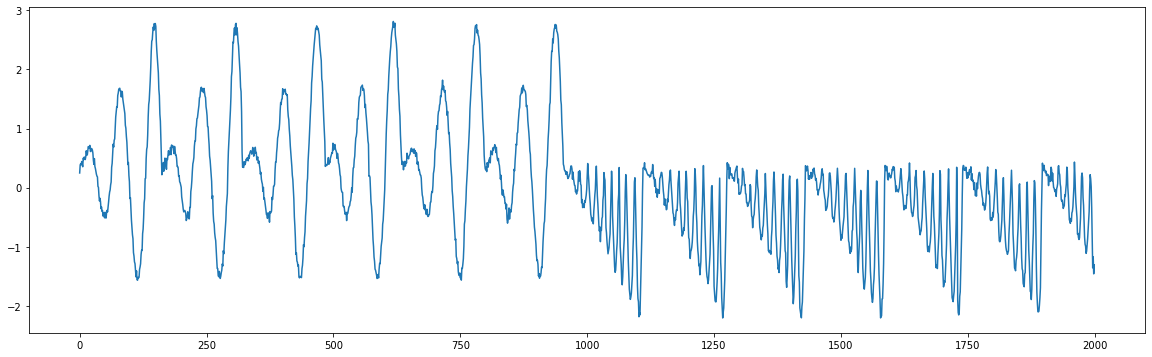

In [6]:
plt.plot(T)
plt.show()

As one can notice, the toy time series above contains two distinct parts, where each part is constructed by a repeatative subsequence. We expect that the snippet algorithm can discover the representative subsequences.

## Finding Snippets

In [7]:
T = warp_add_noise(df) 
m = 200 
k = 2 
s = 70 

snippets, indices, profiles, fractions, areas, regimes = stumpy.snippets(T, m, k, s=s)

## Plotting the snippets

The following figure replicates Fig. 7 of the original paper.

the starting index of the snippet #0 with length m=200 is: 800
the starting index of the snippet #1 with length m=200 is: 1600


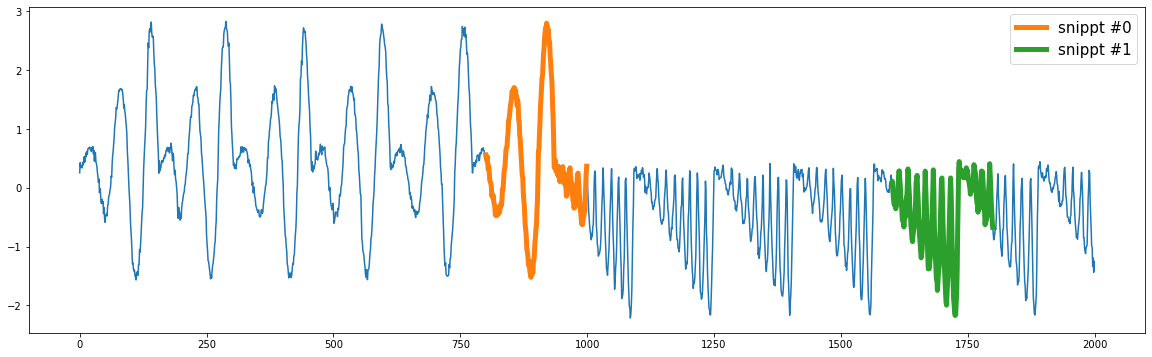

In [8]:
plt.plot(T)
for i in range(k):
    idx = indices[i]
    print(f'the starting index of the snippet #{i} with length m={m} is: {idx}')
    plt.plot(range(idx, idx + m), T[idx : idx + m], lw=5, label='snippt #{}'.format(i))

plt.legend(loc='upper right',fontsize=15)
plt.show()

## Plotting the regimes of snippets

regimes: 
 [[[   0    0  922]]

 [[   1  922 1801]]]
indices slice for the regime of the snippets #0 is: [[  0 922]]
indices slice for the regime of the snippets #1 is: [[ 922 1801]]


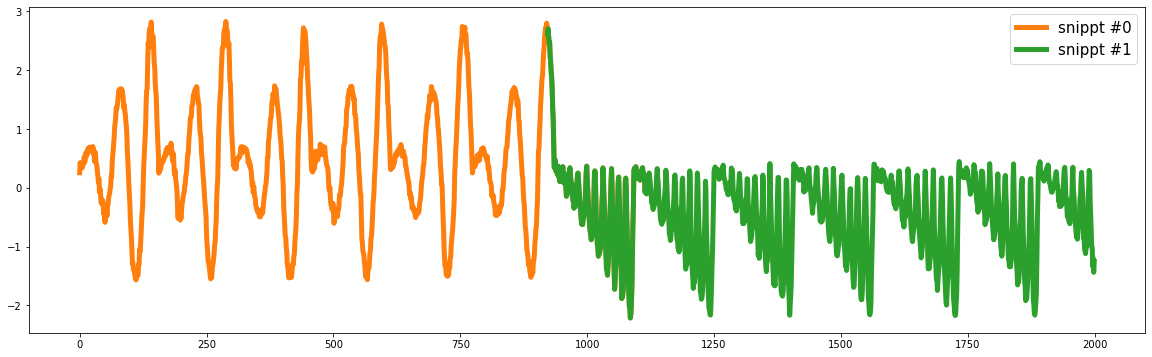

In [9]:
print(f'regimes: \n {regimes}')
print('======================')
###############################

plt.plot(T)

for i in range(k):
    slices_of_indices = regimes[i][:,1:]
    print(f'indices slice for the regime of the snippets #{i} is: {slices_of_indices}')
    
    for per_slice in slices_of_indices:
        start_idx = per_slice[0]
        stop_idx = per_slice[1]+m-1
        plt.plot(range(start_idx,stop_idx),T[start_idx:stop_idx], lw=5, label='snippt #{}'.format(i))

plt.legend(loc='upper right',fontsize=15)
plt.show()

## Plotting the MPdist profile of snippets


The following figure replicates Fig. 8 of the original paper.

The snippet algorithm utilizes MPdist as the distance between two susbequences as it is robust to spikes, warping, linear trends, etc. Let's see how the MPdist profile does look like for the two snippets shown in the previous figure.

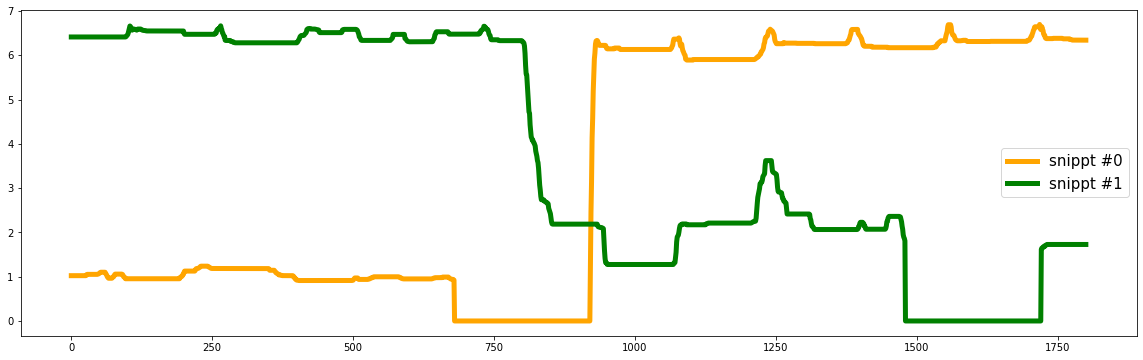

In [10]:
color_vec = ['orange','green']
for i in range(k):
    plt.plot(profiles[i],c=color_vec[i], lw=5, label='snippt #{}'.format(i))

plt.legend(loc='center right',fontsize=15)
plt.show()

As illustrated in the figure above, the MPdist profiles can provide useful insights about the the snippets. Note that the two profiles are mutually exclusive, when one in high, the other is low. These two profiles offer strong clues to the locations of potential time series snippets. They are both approximately “step” functions with their respective low region corresponding to a region that contains subsequences that are similar to the two query patterns.

## Finding optimal k (number of snippets)

To find the optimal number of snippets, a large enough k can be selected. Then, the area under the curve corresponding to each MPdist profile can be used to find the optimal number of snippets. 

The following two figures replicate Fig. 13 (left) and Fig. 13 (right), respectively.

In [11]:
snippets, indices, profiles, fractions, areas, regimes = stumpy.snippets(T, m, k=9, s=s)

C:\Users\nimas\anaconda3\envs\stumpy_env\lib\site-packages\stumpy\snippets.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  snippets_regimes = np.array(snippets_regimes)


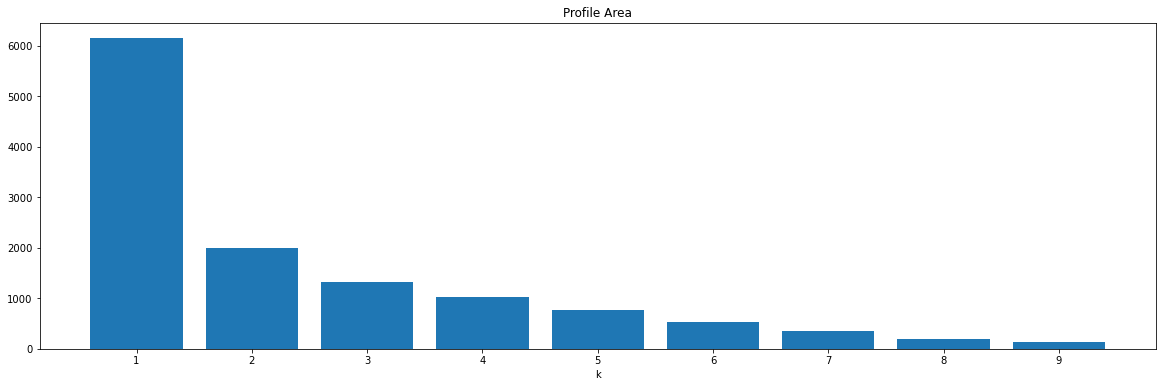

In [12]:
plt.bar(range(1, 10), areas, tick_label=range(1,10))
plt.xlabel("k")
plt.title('Profile Area')
plt.show()

As illustrated above, changing the number of snippets from k=1 to k=2 can significantly change the area under the curve; however, the change in the area is negligible from k=2 to k=3 and so forth. Therefore, the optimal number of snippets is two.

To better observe the changes, we can plot the Change-in-Profile-Area as below:

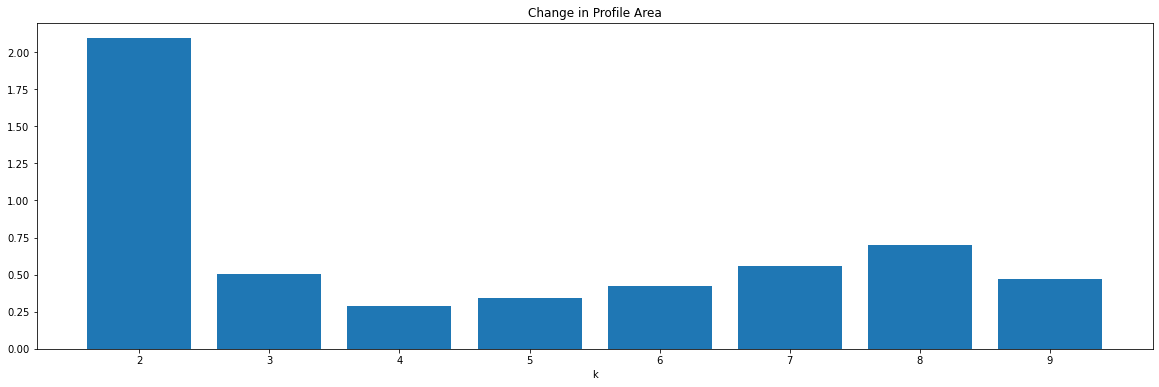

In [13]:
plt.bar(range(2, 10), areas[:-1]/areas[1:] - 1.0, tick_label=range(2,10))
plt.xlabel("k")
plt.title('Change in Profile Area')
plt.show()